In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

In [3]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_ds = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_ds['target'] = boston_data['target']
print(boston_ds.shape)
boston_ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
train_feats = list(boston_ds.drop('target',1).columns)
y_feat = 'target'

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



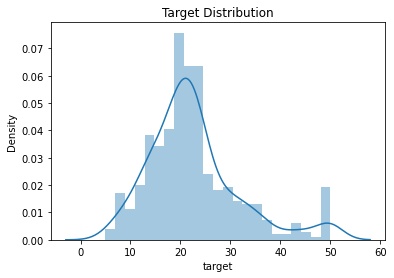

In [5]:
sns.distplot(boston_ds[y_feat])
plt.title('Target Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(boston_ds[train_feats], boston_ds[y_feat], test_size=0.1, random_state=42)
[x.shape for x in [X_train, X_test, y_train,  y_test]]

[(455, 13), (51, 13), (455,), (51,)]

# Check competitors quality

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
def calc_metrics(model_name, y_train, y_test, preds_train, preds_test, ds_full=None):
    q_dict = {}
    for metric in [mean_absolute_error, mean_squared_error, r2_score]:
        q_dict[(metric.__name__,"train")] = metric(y_train, preds_train)
        q_dict[(metric.__name__,"test")] = metric(y_test, preds_test)
    q_dict_ = {model_name:q_dict}
    q_dict = q_dict_
    del q_dict_
    q_dict = pd.DataFrame(q_dict).reset_index().rename(columns={'level_0':'metric','level_1':'ds'})
    
    if ds_full is not None:
        if model_name in ds_full.columns:
            ds_full = ds_full.drop(model_name, 1)
        ds_full = ds_full.merge(q_dict, on=['metric','ds'])
    else:
        ds_full = q_dict
    return ds_full

In [9]:
def plot_metrics(ds, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for m_idx, metric in enumerate(ds['metric'].unique()):
        cds = ds[ds['metric']==metric]

        plt.subplot(1,3,m_idx+1)
        for ds_idx, ds_type in enumerate(['train','test']):
            vals = cds[cds['ds']==ds_type].drop(['metric','ds'],1).values[0]
            plt.barh(np.arange(len(vals))+0.3*ds_idx, vals, height=0.3, label=ds_type)
            for v_idx, v in enumerate(vals):
                plt.text(v, v_idx-0.05+0.3*ds_idx, f"{v:.2f}")
        plt.legend(loc='lower left')
        plt.yticks(np.arange(cds.shape[1]-2), cds.drop(['metric','ds'],1).columns, rotation=0)
        plt.title(metric)
    plt.tight_layout()
    plt.show()    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool


models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(),
          XGBRegressor(), CatBoostRegressor()]
comp_qualities = None
for m in tqdm(models):
    #np.random.seed(42)
    if type(m)==CatBoostRegressor:
        p_train, p_test = Pool(X_train, y_train), Pool(X_test, y_test)
        m.fit(p_train, verbose=False)
        preds_train, preds_test = [m.predict(p) for p in [p_train, p_test]]
    else:
        m.fit(X_train, y_train)
        preds_train, preds_test = [m.predict(p) for p in [X_train, X_test]]
    
    comp_qualities = calc_metrics(m.__class__.__name__, y_train, y_test, preds_train, preds_test, comp_qualities)

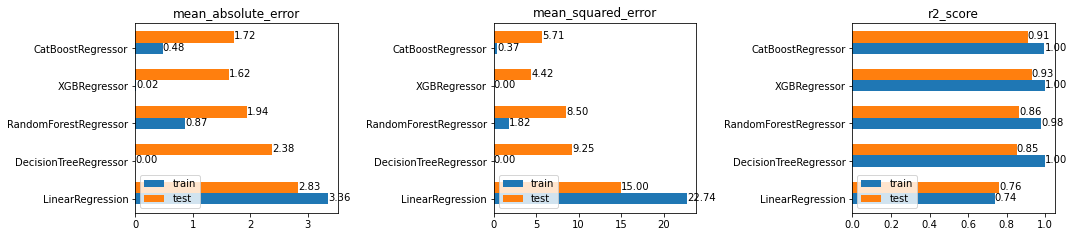

In [11]:
plot_metrics(comp_qualities, figsize=(15,3.4))

# Fit FCA

In [12]:
fcai = reload(fcai)

In [13]:
mvcntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=[])
mvcntx_test = fcai.MultiValuedContext(X_test, y_true=y_test, cat_attrs=[])
fm_mv = fcai.FormalManager(mvcntx_train, task_type='Regression')

In [14]:
%%time
fm_mv.construct_concepts(
    use_tqdm=True, algo='RandomForest',
    rf_params={'random_state':42, 'n_estimators':10, 'max_depth':None})
print(len(fm_mv.get_concepts()))


4034
CPU times: user 1.6 s, sys: 9.6 ms, total: 1.61 s
Wall time: 1.6 s


In [15]:
%%time
fm_mv.construct_lattice(only_spanning_tree=True, use_tqdm=True)


CPU times: user 389 ms, sys: 14.8 ms, total: 404 ms
Wall time: 397 ms


In [16]:
for c in tqdm(fm_mv.get_concepts()):
    c._up_neighbs = {c._up_neighb_st} \
        if c._up_neighb_st is not None else None
    c._low_neighbs = c._low_neighbs_st

fm_mv._calc_concept_levels() # расчёт горизонтальной координаты при отображении понятия

In [17]:
from scipy.sparse import csr_matrix

def predict_fca(self, cntx, metric, W, normalized=False, A=None, exp=False):
    mvals = np.array([c._metrics[metric] for c in self.sort_concepts()])
    if exp:
        mvals = np.log(mvals)

    if A is None:
        n_objs, n_cncpts = len(cntx.get_objs()), len(self.get_concepts())
        
        obj_preds_cncpts = self.trace_context(cntx)[0]
        
        Acoords = np.array([(1,g, c_id)
                       for g, c_ids in obj_preds_cncpts.items() for c_id in c_ids])
        A = csr_matrix((Acoords[:, 0], (Acoords[:, 1].astype(int), Acoords[:, 2].astype(int))),
                shape=(n_objs, n_cncpts))
    #print(A.shape, mvals.shape)
    Am = A.multiply(mvals)
    
    preds = Am.dot(W)#/(X>0).dot(W) 
    if normalized:
        preds = preds/A.dot(W)
    if exp:
        preds = np.exp(preds)
    preds = np.nan_to_num(preds, nan=self.get_concept_by_id(0)._metrics['mean_y_true'])
    return preds, A

In [18]:
def get_best_predictions(self, cntx, verb=False):
    cncpts_active_dict = self.trace_context(cntx)[0]
    preds = []
    for gid in range(len(cntx.get_objs())):
        cncpts_preds = [self.get_concept_by_id(c_id)._metrics['mean_y_true'] for c_id in cncpts_active_dict[gid]]
        if len(cncpts_preds)==0:
            cncpts_preds = [self.get_concept_by_id(0)._metrics['mean_y_true']]
        y_ = cntx._y_true[gid]
        p = min(cncpts_preds) if y_<min(cncpts_preds) else max(cncpts_preds) if y_>max(cncpts_preds) else y_
        if verb:
            print(y_, p, cncpts_preds)
        preds.append(p)
    return preds

In [19]:
best_preds_train = get_best_predictions(fm_mv, mvcntx_train)
best_preds_test = get_best_predictions(fm_mv, mvcntx_test)

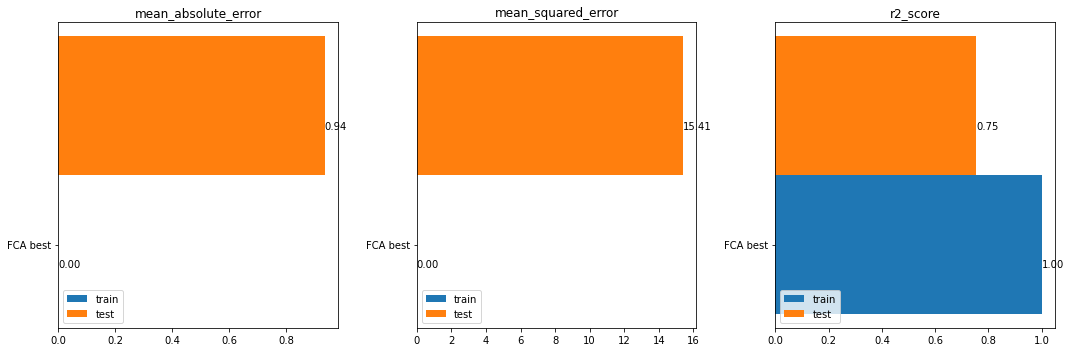

In [20]:
plot_metrics(calc_metrics('FCA best', y_train, y_test, best_preds_train, best_preds_test))

In [21]:
%%time
W0 = np.ones(len(fm_mv.get_concepts()))/len(fm_mv.get_concepts())
preds_train, A_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W0, normalized=True)
preds_test, A_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W0, normalized=True)

CPU times: user 1.37 s, sys: 3.78 ms, total: 1.37 s
Wall time: 1.37 s


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in true_divide



In [22]:
comp_qualities = calc_metrics('FCA equal weights', y_train, y_test, preds_train, preds_test, comp_qualities)

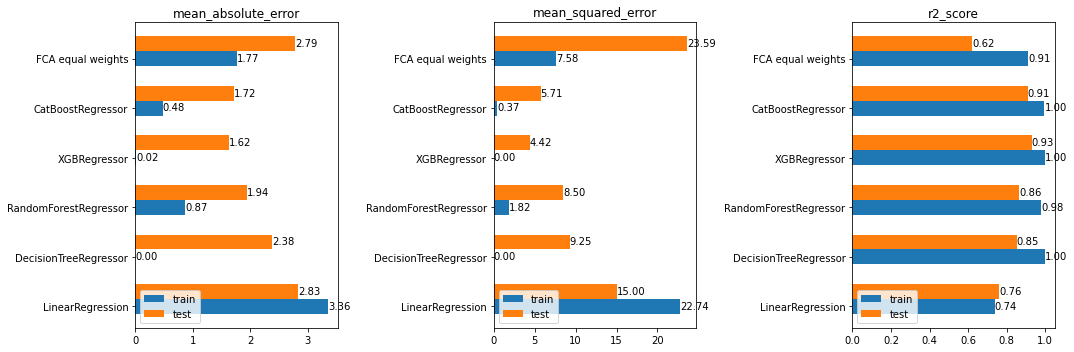

In [23]:
plot_metrics(comp_qualities)

In [24]:
for c in fm_mv.get_concepts():
    if c.get_id()==0:
        mi = 0
    else:
        upn = fm_mv.get_concept_by_id(c._up_neighb_st)
        mi = mvcntx_train._y_true[upn.get_extent()].std(ddof=0)-mvcntx_train._y_true[c.get_extent()].std(ddof=0)
    c._metrics['mi'] = mi
    c._metrics['entropy'] = mvcntx_train._y_true[c.get_extent()].std(ddof=0)

In [25]:
for c in fm_mv.get_concepts():
    c._metrics['weight'] = W0[c.get_id()]

In [26]:
self = fm_mv
cntx = mvcntx_train

In [27]:
obj_cncpts_dict = self.trace_context(cntx)[0]

In [28]:
mvals = np.array([self.get_concept_by_id(c_id)._metrics['mean_y_true'] for c_id in range(len(self.get_concepts()))])

In [29]:
W = W0.copy()

In [30]:
chains = self._get_chains()

In [31]:
%%time
exts = [set(c.get_extent()) for c in fm_mv.sort_concepts()]

Intrs = {c.get_id():{} for c in fm_mv.get_concepts()}
for cid in tqdm(range(len(fm_mv.get_concepts()))):
    for ch in chains:
        is_zero = False
        for cid_ in ch:
            if is_zero:
                #Intrs[cid][cid_] = 0
                #continue
                break
                
            if cid_ not in Intrs[cid]:
                Intrs[cid][cid_] = len(exts[cid]&exts[cid_])/len(exts[cid_])
            
            if Intrs[cid][cid_] == 0:
                is_zero = True


CPU times: user 10.7 s, sys: 148 ms, total: 10.8 s
Wall time: 10.7 s


In [32]:
max([v_ for v in Intrs.values() for v_ in v.values()])

1.0

In [33]:
%%time
Intrs1 = np.array([(v,cid, cid_)
               for cid, cids_ in Intrs.items() for cid_, v in cids_.items()])
Intrs2 = csr_matrix((Intrs1[:, 0], (Intrs1[:, 1].astype(int), Intrs1[:, 2].astype(int))),
        shape=(len(exts),len(exts)))

CPU times: user 1.84 s, sys: 120 ms, total: 1.96 s
Wall time: 1.96 s


In [34]:
Intrs = Intrs2

In [35]:
%%time
exts = [set(c.get_extent()) for c in fm_mv.sort_concepts()]
Intrs_true = []
for cid in tqdm(range(len(W))):
    Intrs_true.append([len(exts[cid]&exts[cid_])/len(exts[cid_]) for cid_ in range(len(W))])
Intrs_true = np.array(Intrs_true)


CPU times: user 6.78 s, sys: 238 ms, total: 7.02 s
Wall time: 6.94 s


In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
W_new = W.copy()
lr = 0.05
mses_train, mses_test = [], []
for i in tqdm(range(1000)):
    gid = np.random.randint(0, len(cntx._y_true))
    
    y_ = cntx._y_true[gid]
    cncpts_preds = mvals[obj_cncpts_dict[gid]]
    W_ = W_new[obj_cncpts_dict[gid]]
    pw = (cncpts_preds*W_).sum()/W_.sum()
    
    grads = -2*(y_-pw)*(cncpts_preds-pw)/W_.sum()
    grads_exp = np.exp(-W_*grads*lr)
    
    entrs = [c._metrics['entropy'] for c in fm_mv.sort_concepts()]
    for cidx, cid in enumerate(obj_cncpts_dict[gid]):
        #W_new *= grads_exp[cidx]*np.exp(entrs[cid]-entrs)
        #intrs = np.array([len(exts[cid]&exts[cid_])/len(exts[cid_]) for cid_ in range(len(exts))])
        intrs = Intrs[cid].toarray()[0]
        ks = np.exp( W_[cidx]*grads[cidx]*lr * intrs * (entrs[cid]-entrs) )
        W_new *= ks
        W_new /= W_new.sum()
    
    if W_new.min()==0 or np.isnan(W_new).sum()>0:
        print(gid)
        break
    
    preds1 = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W_new, normalized=True, exp=False, A=A_train)[0]
    mse_train = mean_squared_error(y_train, preds1)
    mses_train.append(mse_train)
    
    preds1 = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W_new, normalized=True, exp=False, A=A_test)[0]
    mse_test = mean_squared_error(y_test, preds1)
    mses_test.append(mse_test)
    
    if i%50==0:
        print(f'iter {i}: train {mse_train:.4f}, test {mse_test:.4f}')
    if len(mses_train)>50 and mses_train[-1]>max(mses_train[-50-1:-1]):
        print(f'final iter {i}: train {mse_train:.4f}, test {mse_test:.4f}')
        break

iter 0: train 7.2290, test 23.8236
iter 50: train 2.8772, test 21.6542
iter 100: train 1.3664, test 21.2371
iter 150: train 1.0527, test 21.1238
iter 200: train 0.5312, test 20.7890
iter 250: train 0.4561, test 20.7424
iter 300: train 0.4200, test 20.7354
iter 350: train 0.3818, test 20.7411
iter 400: train 0.3579, test 20.7314
iter 450: train 0.3244, test 20.7056
iter 500: train 0.2497, test 20.6570
iter 550: train 0.2396, test 20.6471
iter 600: train 0.2286, test 20.6509
iter 650: train 0.2194, test 20.6455
iter 700: train 0.2084, test 20.6703
iter 750: train 0.2018, test 20.6752
iter 800: train 0.1975, test 20.6652
iter 850: train 0.1901, test 20.6637
iter 900: train 0.1834, test 20.6530
iter 950: train 0.1791, test 20.6543



In [38]:
preds0_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W0, normalized=True, A=A_train, exp=False)[0]
preds1_train = predict_fca(fm_mv, mvcntx_train, 'mean_y_true', W_new, normalized=True, exp=False, A=A_train)[0]

mean_squared_error(y_train, preds0_train), mean_squared_error(y_train, preds1_train)

(7.5779981687581754, 0.17632251765960907)

In [39]:
preds0_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W0, normalized=True, A=A_test, exp=False)[0]
preds1_test = predict_fca(fm_mv, mvcntx_test, 'mean_y_true', W_new, normalized=True, exp=False, A=A_test)[0]

mean_squared_error(y_test, preds0_test), mean_squared_error(y_test, preds1_test)

(23.58624369201407, 20.663869836023732)

In [40]:
plt.rcParams['axes.facecolor'] = 'white'

In [41]:
plt.rcParams['figure.facecolor'] = 'xkcd:white'

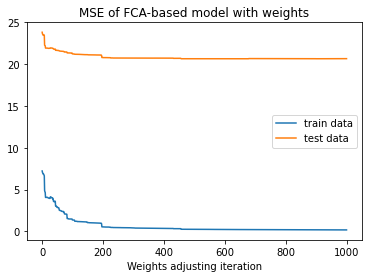

In [42]:
plt.plot(mses_train, label='train data')
plt.plot(mses_test, label='test data')
plt.title('MSE of FCA-based model with weights')
plt.xlabel('Weights adjusting iteration')
plt.legend()
plt.show()

In [43]:
comp_qualities = calc_metrics('FCA adjusted weights', y_train, y_test, preds1_train, preds1_test, comp_qualities)

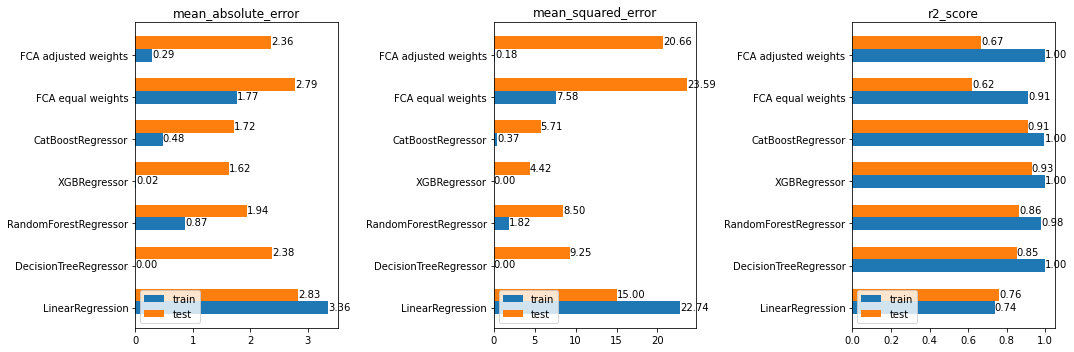

In [44]:
plot_metrics(comp_qualities)